In [69]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import Polygon, mapping

import matplotlib.pyplot as plt
import xarray as xr

#planetary computer
import pystac
import planetary_computer as pc
import odc

from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

In [6]:
original=pd.read_csv('Crop_Location_Data_20221201.csv')

In [7]:
original['lati']=0
original['loti']=0

In [8]:
for x in range(len(original)):
    
    tmp=original['Latitude and Longitude'][x].split(',')
    
    lati=tmp[0]
    original['lati'][x]=lati.lstrip('(')

    loti=tmp[1]
    original['loti'][x]=loti.rstrip(')')

In [9]:
original['loti']=original['loti'].astype('float64')
original['lati']=original['lati'].astype('float64')

ori_gdf=gpd.GeoDataFrame(
    original.loc[:,[c for c in original.columns if (c!='lati') or (c!='loti')]],
    geometry=gpd.points_from_xy(original.loti, original.lati),
    crs='epsg:4326')

ori_gdf.geometry.plot()

ori_gdf['red']=0
ori_gdf['green']=0
ori_gdf['blue']=0
ori_gdf['nir']=0
ori_gdf['ndvi']=0

In [6]:
# number of groups : 7

from sklearn.cluster import KMeans

X=pd.concat([original['lati'],original['loti']],axis=1)

kmeans=KMeans(n_clusters=7, random_state=0)
clusters=kmeans.fit(X)

original['cluster']=clusters.labels_

In [11]:
original.head()

,Latitude and Longitude,Class of Land,lati,loti
0,"(10.323727047081501, 105.2516346045924)",Rice,10.323727,105.251635
1,"(10.322364360592521, 105.27843410554115)",Rice,10.322364,105.278434
2,"(10.321455902933202, 105.25254306225168)",Rice,10.321456,105.252543
3,"(10.324181275911162, 105.25118037576274)",Rice,10.324181,105.251180
4,"(10.324635504740822, 105.27389181724476)",Rice,10.324636,105.273892


In [10]:
len(original)

600

plt.scatter(original.lati, original.loti, c=original.cluster)

ori_gdf['cluster'].value_counts()

ori_gdf.info()

g0=ori_gdf[ori_gdf['cluster']==0]
g1=ori_gdf[ori_gdf['cluster']==1]
g2=ori_gdf[ori_gdf['cluster']==2]
g3=ori_gdf[ori_gdf['cluster']==3]
g4=ori_gdf[ori_gdf['cluster']==4]
g5=ori_gdf[ori_gdf['cluster']==5]
g6=ori_gdf[ori_gdf['cluster']==6]

g0.reset_index(drop=True, inplace=True)
g1.reset_index(drop=True, inplace=True)
g2.reset_index(drop=True, inplace=True)
g3.reset_index(drop=True, inplace=True)
g4.reset_index(drop=True, inplace=True)
g5.reset_index(drop=True, inplace=True)
g6.reset_index(drop=True, inplace=True)

### Getting the sentinel Data

In [16]:
def first_def(df, month):
    
    lalo=df.columns[0]
    tmp=list(df[lalo])
    
    for x in range(len(tmp)):
        
        lati=float(tmp[x].replace('(','').replace(')','').replace(' ','').split(',')[0])
        loti=float(tmp[x].replace('(','').replace(')','').replace(' ','').split(',')[1])
        
    
        catalog = Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=pc.sign_inplace,)
    
        a=lati-0.05
        b=loti-0.05

        c=lati+0.05
        d=loti+0.05

        bbox_of_interest=(b,a,d,c)

        if month==1:
            time_window="2019-01-01/2019-01-31"
        elif month==2:
            time_window="2019-02-01/2019-02-28"
        elif month==3:
            time_window="2019-03-01/2019-03-31"
        elif month==5:
            time_window="2019-05-01/2019-05-31"
        elif month==6:
            time_window="2019-06-01/2019-06-30"
        elif month==9:
            time_window="2019-09-01/2019-09-30"
        elif month==10:
            time_window="2019-10-01/2019-10-31"

            
            
            
            
        search = catalog.search(
            collections=["sentinel-2-l2a"], bbox=bbox_of_interest, datetime=time_window)

        items = search.get_all_items()
        gdf=gpd.GeoDataFrame.from_features(items.to_dict(), crs='epsg:4326')
        date=gdf[gdf['eo:cloud_cover']==min(gdf['eo:cloud_cover'])]['datetime'].values[0]
            
        list_items=list(items)
        
        resolution=20
        scale=resolution/111320

        xx = stac_load(
            items,
            bands=["red","nir","SCL"],
            crs="EPSG:4326", # Latitude-Longitude
            resolution=scale, # Degrees
            chunks={"x": 2048, "y": 2048},
            dtype="uint16",
            patch_url=pc.sign,
            bbox=bbox_of_interest
        )    

        cloud_mask = \
        (xx.SCL != 0) & \
        (xx.SCL != 1) & \
        (xx.SCL != 3) & \
        (xx.SCL != 6) & \
        (xx.SCL != 8) & \
        (xx.SCL != 9) & \
        (xx.SCL != 10) 

        cleaned_data = xx.where(cloud_mask).astype("uint16")
        
        cleaned_data=cleaned_data.assign(ndvi=lambda x: (x.nir-x.red)/(x.nir+x.red))

        final=cleaned_data.sel(time=date)
                
        nir=str('nir_{0}'.format(str(month)))
        ndvi=str('ndvi_{0}'.format(str(month)))
        
        df[str(nir)][x]=float(final.sel(latitude=lati, longitude=loti, method='nearest').nir.compute().values)
        df[str(ndvi)][x]=float(final.sel(latitude=lati, longitude=loti, method='nearest').ndvi.compute().values)
        
        

In [31]:
def second_def(df, month):
    
    lalo=df.columns[0]
    tmp=list(df[lalo])
    
    for x in range(len(tmp)):
        
        lati=float(tmp[x].replace('(','').replace(')','').replace(' ','').split(',')[0])
        loti=float(tmp[x].replace('(','').replace(')','').replace(' ','').split(',')[1])
        
    
        catalog = Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=pc.sign_inplace,)
    
        a=lati-0.05
        b=loti-0.05

        c=lati+0.05
        d=loti+0.05

        bbox_of_interest=(b,a,d,c)

        if month==1:
            time_window="2019-01-01/2019-01-31"
        elif month==2:
            time_window="2019-02-01/2019-02-28"
        elif month==3:
            time_window="2019-03-01/2019-03-31"
        elif month==5:
            time_window="2019-05-01/2019-05-31"
        elif month==6:
            time_window="2019-06-01/2019-06-30"
        elif month==9:
            time_window="2019-09-01/2019-09-30"
        elif month==10:
            time_window="2019-10-01/2019-10-31"

            
            
            
            
        search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_window)

        items = list(search.get_all_items())
        bands_of_interest = ['vh','vv']
        
        data = stac_load([items[0]], patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
        vh = data["vh"].astype("float").values.tolist()[0][0]
        vv = data["vv"].astype("float").values.tolist()[0][0]

        var_vv=str('vv_{0}'.format(str(month)))
        var_vh=str('vh_{0}'.format(str(month)))
        
        df[str(var_vv)][x]=vv
        df[str(var_vh)][x]=vh        

In [23]:
mon=[1,2,3,5,6,9,10]
mon=[1,2]
value=['nir','ndvi']
for string in mon:
    for val in value:
        var_name='{0}_{1}'.format(val, string)
        original[var_name]=0

In [24]:
original.columns

Index(['Latitude and Longitude', 'Class of Land', 'lati', 'loti', 'nir_1',
       'ndvi_1', 'nir_2', 'ndvi_2', 'nir_3', 'ndvi_3', 'nir_5', 'ndvi_5',
       'nir_6', 'ndvi_6', 'nir_9', 'ndvi_9', 'nir_10', 'ndvi_10'],
      dtype='object')

In [25]:
for string in mon:
    first_def(original,string)

In [20]:
original.head()

,Latitude and Longitude,Class of Land,lati,loti,nir_1,ndvi_1,nir_2,ndvi_2,nir_3,ndvi_3,nir_5,ndvi_5,nir_6,ndvi_6,nir_9,ndvi_9,nir_10,ndvi_10
0,"(10.323727047081501, 105.2516346045924)",Rice,10.323727,105.251635,1360,0.599059,4018,0.884174,3994,0.784629,2730,0.791926,3552,0.866036,4796,0.811862,734,0.819083
1,"(10.322364360592521, 105.27843410554115)",Rice,10.322364,105.278434,1836,0.602094,3670,0.847006,4396,0.789902,4000,0.877053,3928,0.828678,2298,0.710458,3538,0.871463
2,"(10.321455902933202, 105.25254306225168)",Rice,10.321456,105.252543,1688,0.638835,3476,0.847462,3980,0.765358,2684,0.747396,3776,0.811031,3686,0.815316,1926,0.603664
3,"(10.324181275911162, 105.25118037576274)",Rice,10.324181,105.251180,2722,0.831147,3802,0.857806,4640,0.627499,3094,0.784828,3732,0.829412,4732,0.745160,750,0.835985
4,"(10.324635504740822, 105.27389181724476)",Rice,10.324636,105.273892,2348,0.767407,4388,0.862479,4688,0.797201,3260,0.830432,3572,0.892450,3962,0.829601,3716,0.900767


In [27]:
for x in original.columns:
    print(original[x].isnull().sum(), x)

0 Latitude and Longitude
0 Class of Land
0 lati
0 loti
0 nir_1
293 ndvi_1
0 nir_2
242 ndvi_2
0 nir_3
282 ndvi_3
0 nir_5
268 ndvi_5
0 nir_6
279 ndvi_6
0 nir_9
373 ndvi_9
0 nir_10
330 ndvi_10


In [28]:
mon=[1,2,3,5,6,9,10]
value=['vv','vh']
for string in mon:
    for val in value:
        var_name='{0}_{1}'.format(val, string)
        original[var_name]=0

In [29]:
original.columns

Index(['Latitude and Longitude', 'Class of Land', 'lati', 'loti', 'nir_1',
       'ndvi_1', 'nir_2', 'ndvi_2', 'nir_3', 'ndvi_3', 'nir_5', 'ndvi_5',
       'nir_6', 'ndvi_6', 'nir_9', 'ndvi_9', 'nir_10', 'ndvi_10', 'vv_1',
       'vh_1', 'vv_2', 'vh_2', 'vv_3', 'vh_3', 'vv_5', 'vh_5', 'vv_6', 'vh_6',
       'vv_9', 'vh_9', 'vv_10', 'vh_10'],
      dtype='object')

In [32]:
for string in mon:
    second_def(original,string)

In [33]:
for x in original.columns:
    print(original[x].isnull().sum(), x)

0 Latitude and Longitude
0 Class of Land
0 lati
0 loti
0 nir_1
293 ndvi_1
0 nir_2
242 ndvi_2
0 nir_3
282 ndvi_3
0 nir_5
268 ndvi_5
0 nir_6
279 ndvi_6
0 nir_9
373 ndvi_9
0 nir_10
330 ndvi_10
0 vv_1
0 vh_1
0 vv_2
0 vh_2
0 vv_3
0 vh_3
0 vv_5
0 vh_5
0 vv_6
0 vh_6
0 vv_9
0 vh_9
0 vv_10
0 vh_10


In [34]:
original.columns

Index(['Latitude and Longitude', 'Class of Land', 'lati', 'loti', 'nir_1',
       'ndvi_1', 'nir_2', 'ndvi_2', 'nir_3', 'ndvi_3', 'nir_5', 'ndvi_5',
       'nir_6', 'ndvi_6', 'nir_9', 'ndvi_9', 'nir_10', 'ndvi_10', 'vv_1',
       'vh_1', 'vv_2', 'vh_2', 'vv_3', 'vh_3', 'vv_5', 'vh_5', 'vv_6', 'vh_6',
       'vv_9', 'vh_9', 'vv_10', 'vh_10'],
      dtype='object')

In [37]:
valid_rows=original[['Latitude and Longitude', 'Class of Land', 'lati', 'loti', 'nir_1',
       'ndvi_1', 'nir_2', 'ndvi_2', 'nir_3', 'ndvi_3', 'nir_5', 'ndvi_5',
       'nir_6', 'ndvi_6', 'nir_9', 'ndvi_9', 'nir_10', 'ndvi_10', 'vv_1',
       'vh_1', 'vv_2', 'vh_2', 'vv_3', 'vh_3', 'vv_5', 'vh_5', 'vv_6', 'vh_6',
       'vv_9', 'vh_9', 'vv_10', 'vh_10']].notnull().all(1)

In [38]:
ori_null=original[~valid_rows]
ori_not_null=original[valid_rows]

In [39]:
copy_1=ori_null.copy()
copy_2=ori_not_null.copy()

In [40]:
len(copy_1), len(copy_2)

(429, 171)

copy['mean_ndvi']=copy[['ndvi_2','ndvi_3','ndvi_5','ndvi_6','ndvi_9','ndvi_10']].mean(axis=1)

copy.columns

In [41]:
#crop_data=copy[['lati','loti','ndvi_2','ndvi_3','ndvi_5','ndvi_6','ndvi_9','ndvi_10','Class of Land']]
#crop_data=copy[['lati','loti','mean_ndvi','Class of Land']]
crop_data_null=copy_1[['Class of Land', 'lati', 'loti', 'vv_1',
       'vh_1', 'vv_2', 'vh_2', 'vv_3', 'vh_3', 'vv_5', 'vh_5', 'vv_6', 'vh_6',
       'vv_9', 'vh_9', 'vv_10', 'vh_10']]

crop_data_not_null=copy_2[['Class of Land', 'lati', 'loti', 'nir_1',
       'ndvi_1', 'nir_2', 'ndvi_2', 'nir_3', 'ndvi_3', 'nir_5', 'ndvi_5',
       'nir_6', 'ndvi_6', 'nir_9', 'ndvi_9', 'nir_10', 'ndvi_10', 'vv_1',
       'vh_1', 'vv_2', 'vh_2', 'vv_3', 'vh_3', 'vv_5', 'vh_5', 'vv_6', 'vh_6',
       'vv_9', 'vh_9', 'vv_10', 'vh_10']]

## Rows with Null values

In [43]:
X_null=crop_data_null.drop(columns=['Class of Land']).values
y_null=crop_data_null['Class of Land'].values

X_train, X_test, y_train, y_test = train_test_split(X_null,y_null,test_size=0.3, stratify=y_null,random_state=40)

In [48]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
clf4 = XGBClassifier()
clf5 = GradientBoostingClassifier()
clf6 = DecisionTreeClassifier()

eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3),('xgb',clf4),('gbc',clf5),('dt',clf6)], voting='hard')
eclf1.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1)),
                             ('gnb', GaussianNB()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_cate...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('gbc', GradientBoostingClassifier()),
                             ('dt', DecisionTreeClassifier())])

model=LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)

In [49]:
insample_predictions=eclf1.predict(X_train)

In [50]:
print(classification_report(insample_predictions, y_train))

              precision    recall  f1-score   support

    Non Rice       1.00      1.00      1.00       176
        Rice       1.00      1.00      1.00       124

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [51]:
outsample_predictions=eclf1.predict(X_test)

In [52]:
print(classification_report(outsample_predictions, y_test))

              precision    recall  f1-score   support

    Non Rice       1.00      1.00      1.00        75
        Rice       1.00      1.00      1.00        54

    accuracy                           1.00       129
   macro avg       1.00      1.00      1.00       129
weighted avg       1.00      1.00      1.00       129



## Rows with whole variables

In [53]:
X_not_null=crop_data_not_null.drop(columns=['Class of Land']).values
y_not_null=crop_data_not_null['Class of Land'].values

X_train, X_test, y_train, y_test = train_test_split(X_not_null,y_not_null,test_size=0.3, stratify=y_not_null,random_state=40)

In [55]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
clf4 = XGBClassifier()
clf5 = GradientBoostingClassifier()
clf6 = DecisionTreeClassifier()

eclf2 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3),('xgb',clf4),('gbc',clf5),('dt',clf6)], voting='hard')
eclf2.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1)),
                             ('gnb', GaussianNB()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_cate...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('gbc', GradientBoostingClassifier()),
                             ('dt', DecisionTreeClassifier())])

In [56]:
insample_predictions=eclf2.predict(X_train)

In [57]:
print(classification_report(insample_predictions, y_train))

              precision    recall  f1-score   support

    Non Rice       1.00      1.00      1.00        34
        Rice       1.00      1.00      1.00        85

    accuracy                           1.00       119
   macro avg       1.00      1.00      1.00       119
weighted avg       1.00      1.00      1.00       119



In [59]:
outsample_predictions=eclf2.predict(X_test)

In [60]:
print(classification_report(outsample_predictions, y_test))

              precision    recall  f1-score   support

    Non Rice       1.00      1.00      1.00        15
        Rice       1.00      1.00      1.00        37

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52



# Submission file preprocessing

In [105]:
sub=pd.read_csv('challenge_1_submission_template_correct_columns_fixed.csv')

In [106]:
sub['lati']=0
sub['loti']=0

In [107]:
for x in range(len(sub)):
    
    tmp=sub['id'][x].split(',')
    
    lati=tmp[0]
    sub['lati'][x]=lati.lstrip('(')

    loti=tmp[1]
    sub['loti'][x]=loti.rstrip(')')

In [108]:
sub['loti']=sub['loti'].astype('float64')
sub['lati']=sub['lati'].astype('float64')

In [65]:
sub_gdf=gpd.GeoDataFrame(
    sub.loc[:,[c for c in sub.columns if (c!='lati') or (c!='loti')]],
    geometry=gpd.points_from_xy(sub.loti, sub.lati),
    crs='epsg:4326')

<AxesSubplot:>

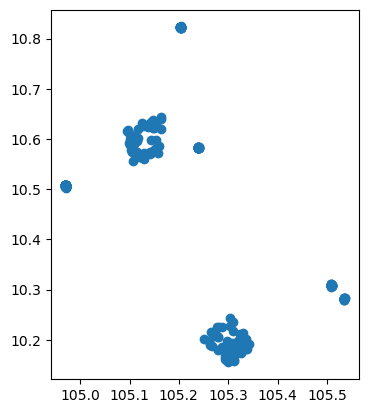

In [66]:
sub_gdf.geometry.plot()

In [67]:
X=pd.concat([sub['lati'],sub['loti']],axis=1)

In [70]:
kmeans_sub=KMeans(n_clusters=7, random_state=0)
clusters=kmeans_sub.fit(X)

In [71]:
sub['cluster']=clusters.labels_

In [72]:
sub.head()

,id,target,lati,loti,cluster
0,"(10.18019073690894, 105.32022315786804)",NaN,10.180191,105.320223,0
1,"(10.561107033461816, 105.12772097986661)",NaN,10.561107,105.127721,1
2,"(10.623790611954897, 105.13771401411867)",NaN,10.623791,105.137714,6
3,"(10.583364246115156, 105.23946127195805)",NaN,10.583364,105.239461,5
4,"(10.20744446668854, 105.26844107128906)",NaN,10.207444,105.268441,0


In [73]:
len(sub)

250

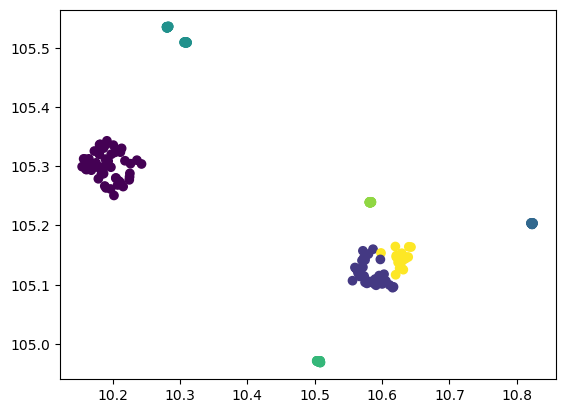

In [75]:
plt.scatter(sub.lati, sub.loti, c=sub.cluster)

In [76]:
mon=[1,2,3,5,6,9,10]
value=['nir','ndvi']
for string in mon:
    for val in value:
        var_name='{0}_{1}'.format(val, string)
        sub[var_name]=0

In [77]:
sub.head()

,id,target,lati,loti,cluster,nir_1,ndvi_1,nir_2,ndvi_2,nir_3,ndvi_3,nir_5,ndvi_5,nir_6,ndvi_6,nir_9,ndvi_9,nir_10,ndvi_10
0,"(10.18019073690894, 105.32022315786804)",NaN,10.180191,105.320223,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"(10.561107033461816, 105.12772097986661)",NaN,10.561107,105.127721,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"(10.623790611954897, 105.13771401411867)",NaN,10.623791,105.137714,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"(10.583364246115156, 105.23946127195805)",NaN,10.583364,105.239461,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"(10.20744446668854, 105.26844107128906)",NaN,10.207444,105.268441,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [78]:
for string in mon:
    first_def(sub,string)

In [80]:
mon=[1,2,3,5,6,9,10]
value=['vv','vh']
for string in mon:
    for val in value:
        var_name='{0}_{1}'.format(val, string)
        sub[var_name]=0

In [82]:
for string in mon:
    second_def(sub,string)

In [83]:
for x in sub.columns:
    print(sub[x].isnull().sum(), x)

0 id
250 target
0 lati
0 loti
0 cluster
0 nir_1
89 ndvi_1
0 nir_2
80 ndvi_2
0 nir_3
93 ndvi_3
0 nir_5
155 ndvi_5
0 nir_6
89 ndvi_6
0 nir_9
129 ndvi_9
0 nir_10
141 ndvi_10
0 vv_1
0 vh_1
0 vv_2
0 vh_2
0 vv_3
0 vh_3
0 vv_5
0 vh_5
0 vv_6
0 vh_6
0 vv_9
0 vh_9
0 vv_10
0 vh_10


In [84]:
sub.head()

,id,target,lati,loti,cluster,nir_1,ndvi_1,nir_2,ndvi_2,nir_3,...,vv_3,vh_3,vv_5,vh_5,vv_6,vh_6,vv_9,vh_9,vv_10,vh_10
0,"(10.18019073690894, 105.32022315786804)",NaN,10.180191,105.320223,0,5444,0.922316,4040,0.701769,3560,...,0.085975,0.014124,0.050962,0.015588,0.117839,0.027412,0.160930,0.039919,0.251064,0.023595
1,"(10.561107033461816, 105.12772097986661)",NaN,10.561107,105.127721,1,0,NaN,0,NaN,0,...,0.232372,0.025434,0.154734,0.025422,0.169286,0.032697,0.008950,0.002188,0.040987,0.004627
2,"(10.623790611954897, 105.13771401411867)",NaN,10.623791,105.137714,6,0,NaN,0,NaN,0,...,0.541846,0.229858,0.023960,0.019652,0.124226,0.017241,0.175632,0.015016,0.477561,0.065075
3,"(10.583364246115156, 105.23946127195805)",NaN,10.583364,105.239461,5,0,NaN,0,NaN,0,...,0.146795,0.031435,0.431488,0.031099,0.029118,0.015925,0.012650,0.001957,0.064742,0.010193
4,"(10.20744446668854, 105.26844107128906)",NaN,10.207444,105.268441,0,4708,0.929508,3870,0.714665,2492,...,0.174054,0.050984,0.086918,0.028190,0.061681,0.029826,0.407519,0.027851,0.142674,0.014306


In [85]:
sub.columns

Index(['id', 'target', 'lati', 'loti', 'cluster', 'nir_1', 'ndvi_1', 'nir_2',
       'ndvi_2', 'nir_3', 'ndvi_3', 'nir_5', 'ndvi_5', 'nir_6', 'ndvi_6',
       'nir_9', 'ndvi_9', 'nir_10', 'ndvi_10', 'vv_1', 'vh_1', 'vv_2', 'vh_2',
       'vv_3', 'vh_3', 'vv_5', 'vh_5', 'vv_6', 'vh_6', 'vv_9', 'vh_9', 'vv_10',
       'vh_10'],
      dtype='object')

In [86]:
valid_rows=sub[['id','lati', 'loti', 'nir_1',
       'ndvi_1', 'nir_2', 'ndvi_2', 'nir_3', 'ndvi_3', 'nir_5', 'ndvi_5',
       'nir_6', 'ndvi_6', 'nir_9', 'ndvi_9', 'nir_10', 'ndvi_10', 'vv_1',
       'vh_1', 'vv_2', 'vh_2', 'vv_3', 'vh_3', 'vv_5', 'vh_5', 'vv_6', 'vh_6',
       'vv_9', 'vh_9', 'vv_10', 'vh_10']].notnull().all(1)

In [87]:
sub_null=sub[~valid_rows]
sub_not_null=sub[valid_rows]

In [88]:
copy_1=sub_null.copy()
copy_2=sub_not_null.copy()

In [91]:
crop_data_null=copy_1[['lati', 'loti', 'vv_1',
       'vh_1', 'vv_2', 'vh_2', 'vv_3', 'vh_3', 'vv_5', 'vh_5', 'vv_6', 'vh_6',
       'vv_9', 'vh_9', 'vv_10', 'vh_10']]

crop_data_not_null=copy_2[['lati', 'loti', 'nir_1',
       'ndvi_1', 'nir_2', 'ndvi_2', 'nir_3', 'ndvi_3', 'nir_5', 'ndvi_5',
       'nir_6', 'ndvi_6', 'nir_9', 'ndvi_9', 'nir_10', 'ndvi_10', 'vv_1',
       'vh_1', 'vv_2', 'vh_2', 'vv_3', 'vh_3', 'vv_5', 'vh_5', 'vv_6', 'vh_6',
       'vv_9', 'vh_9', 'vv_10', 'vh_10']]

## Rows with Null values

In [93]:
final_predictions_null=eclf1.predict(crop_data_null)
final_prediction_series_null=pd.Series(final_predictions_null)

In [94]:
final_prediction_series_null.value_counts()

Non Rice    169
Rice         36
dtype: int64

In [95]:
final_prediction_series_null

0          Rice
1      Non Rice
2      Non Rice
3      Non Rice
4          Rice
         ...   
200    Non Rice
201    Non Rice
202    Non Rice
203    Non Rice
204    Non Rice
Length: 205, dtype: object

In [96]:
#submission_df = pd.DataFrame({'id':sub['id'].values, 'target':final_prediction_series_null.values})
submission_df_null = pd.DataFrame({'id':copy_1['id'].values, 'target':final_prediction_series_null.values})

In [97]:
submission_df_null.head()

,id,target
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Non Rice
2,"(10.623790611954897, 105.13771401411867)",Non Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice


## Rows with whole variables

In [98]:
final_predictions_not_null=eclf2.predict(crop_data_not_null)
final_prediction_series_not_null=pd.Series(final_predictions_not_null)

In [99]:
final_prediction_series_not_null.value_counts()

Rice        26
Non Rice    19
dtype: int64

In [100]:
final_prediction_series_not_null

0         Rice
1         Rice
2     Non Rice
3         Rice
4         Rice
5     Non Rice
6     Non Rice
7         Rice
8         Rice
9         Rice
10        Rice
11    Non Rice
12    Non Rice
13        Rice
14    Non Rice
15    Non Rice
16        Rice
17    Non Rice
18    Non Rice
19    Non Rice
20        Rice
21    Non Rice
22        Rice
23    Non Rice
24    Non Rice
25        Rice
26        Rice
27    Non Rice
28        Rice
29        Rice
30        Rice
31        Rice
32    Non Rice
33        Rice
34    Non Rice
35        Rice
36        Rice
37        Rice
38        Rice
39        Rice
40        Rice
41        Rice
42    Non Rice
43    Non Rice
44    Non Rice
dtype: object

In [102]:
submission_df_not_null = pd.DataFrame({'id':copy_2['id'].values, 'target':final_prediction_series_not_null.values})

In [211]:
submission_df_not_null.head()

,id,target
0,"(10.822288610516317, 105.20221450792755)",Rice
1,"(10.225159391045281, 105.28206793617827)",Rice
2,"(10.281029537093461, 105.53416493662849)",Non Rice
3,"(10.16610964318948, 105.30614206414918)",Rice
4,"(10.586543847922776, 105.15997122677103)",Rice


## Prepare for submission file

In [209]:
sub_id=sub[['id','target']]

In [218]:
tmping=pd.concat([submission_df_null,submission_df_not_null])

In [219]:
tmping['target'].value_counts()

Non Rice    188
Rice         62
Name: target, dtype: int64

In [220]:
tmping.head()

,id,target
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Non Rice
2,"(10.623790611954897, 105.13771401411867)",Non Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice


In [221]:
mid=sub_id.merge(tmping,on='id',how='left')

In [222]:
mid.head()

,id,target_x,target_y
0,"(10.18019073690894, 105.32022315786804)",NaN,Rice
1,"(10.561107033461816, 105.12772097986661)",NaN,Non Rice
2,"(10.623790611954897, 105.13771401411867)",NaN,Non Rice
3,"(10.583364246115156, 105.23946127195805)",NaN,Non Rice
4,"(10.20744446668854, 105.26844107128906)",NaN,Rice


In [223]:
mid['target_y'].isnull().sum()

0

In [224]:
final_sub=mid[['id','target_y']]

In [225]:
final_sub.columns=['id','target']

In [226]:
final_sub.head(100)

,id,target
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Non Rice
2,"(10.623790611954897, 105.13771401411867)",Non Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
95,"(10.507053802732276, 104.97010357598151)",Non Rice
96,"(10.559744346972836, 105.12908366635551)",Non Rice
97,"(10.280121079434142, 105.53552762311739)",Non Rice
98,"(10.190183771161461, 105.26344455416304)",Rice


In [228]:
final_sub['target'].value_counts()

Non Rice    188
Rice         62
Name: target, dtype: int64

In [229]:
final_sub.to_csv('Submission/submission-new-6.csv',index=False)